# Spatial analysis of Xenium Dataset

In [1]:
# <a href="https://colab.research.google.com/github/pachterlab/voyagerpy/blob/main/examples/xenium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

...

In [2]:
import sys
import subprocess

def install_packages_colab():
    """Install Python packages using pip."""
    packages = [
        'voyagerpy==0.1.1',
        'gget==0.28.4',
        'watermark==2.4.3',
        'scanpy==1.10.1'
    ]
    # Command construction for pip install
    command = [sys.executable, '-m', 'pip', 'install'] + packages
    try:
        # Execute the command
        subprocess.check_call(command)
        print("Packages installed successfully.")
    except subprocess.CalledProcessError:
        print("Failed to install packages.")
        raise

if 'google.colab' in sys.modules:  # if in google colab
    install_packages_colab()

In [3]:
import voyagerpy as vp

# Data handling and plotting
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# File management and downloading
import os
import tarfile
import requests
import pathlib
import json
import gget  # mapping ensembl gene IDs to gene symbols
import re

# Graph/matrix handling
import networkx as nx  # graph generation
from scipy.sparse import csr_matrix, issparse  # matrix handling
import scanpy as sc  # PCA and KNN

# Image handling
from scipy.ndimage import binary_opening, binary_closing, binary_fill_holes
from skimage.measure import label, regionprops
from skimage import color, morphology
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from shapely.affinity import scale
from matplotlib.lines import Line2D
from shapely.geometry import Point
from shapely.predicates import contains
from scipy.stats import gaussian_kde

plt.rcParams['axes.grid'] = False
plt.rcParams['axes.edgecolor'] = 'none'  # Hides the axes border
# plt.rcParams['xtick.color'] = 'none'  # Hides x-axis ticks
# plt.rcParams['ytick.color'] = 'none'  # Hides y-axis ticks

plt.rcParams['figure.dpi'] = 120

# Turn on matplotlib interactive mode so we don't need to explicitly call plt.show()
_ = plt.ion()

In [4]:
root_dir = pathlib.Path(os.getcwd())
outs_dir = pathlib.Path(f'{root_dir}/outs/xenium')

outs_dir.mkdir(parents=True, exist_ok=True)

def download_data(tar_path, url_reads, outs_dir = outs_dir):
    if not tar_path.exists():
        res = requests.get(url_reads)
        with tar_path.open('wb') as f:
            f.write(res.content)

        try:
            with tarfile.open(tar_path, 'r') as tar:
                tar.extractall(path=outs_dir)
                print("Extraction completed successfully!")
        except Exception as e:
            print(f"An error occurred: {e}")

In [5]:
# Download the unfiltered gene count matrix
box_link = "https://caltech.box.com/shared/static/m8g4ltvwqm2ych7b3ua9ibx94ozacttc.gz"

tar_path = outs_dir / 'xenium_data.tar.gz'
url_reads = box_link
# download_data(tar_path, url_reads)

In [6]:
import h5py

# Path to the HDF5 file
file_path = "/workspace/examples/outs/xenium/xenium2_pancreas/cell_feature_matrix.h5"

# Open the HDF5 file
with h5py.File(file_path, "r") as f:
    # Function to recursively print the structure of the HDF5 file
    def print_structure(name, obj):
        print(name)
    
    # Print the structure of the file
    f.visititems(print_structure)


matrix
matrix/barcodes
matrix/data
matrix/features
matrix/features/_all_tag_keys
matrix/features/feature_type
matrix/features/genome
matrix/features/id
matrix/features/name
matrix/indices
matrix/indptr
matrix/shape


In [7]:
import h5py
import numpy as np
import pandas as pd
import scanpy as sc

# Path to the HDF5 file
file_path = "/workspace/examples/xenium/xenium2_pancreas/cell_feature_matrix.h5"

# Open the HDF5 file
with h5py.File(file_path, "r") as f:
    # Read the datasets
    barcodes = f['matrix/barcodes'][:].astype(str)
    data = f['matrix/data'][:]
    feature_names = f['matrix/features/name'][:].astype(str)
    feature_types = f['matrix/features/feature_type'][:].astype(str)
    indices = f['matrix/indices'][:]
    indptr = f['matrix/indptr'][:]
    shape = f['matrix/shape'][:]

    # Create a sparse matrix
    from scipy.sparse import csr_matrix
    X = csr_matrix((data, indices, indptr), shape=(shape[1], shape[0]))

    # Create DataFrames for obs and var
    obs = pd.DataFrame(index=barcodes)
    var = pd.DataFrame(index=feature_names)
    var['feature_type'] = feature_types
    
    # Create AnnData object
    adata = sc.AnnData(X=X, obs=obs, var=var)

# Check the contents of the AnnData object
print(adata)

AnnData object with n_obs × n_vars = 140702 × 541
    var: 'feature_type'


In [8]:
adata.var

,feature_type
ABCC11,Gene Expression
ACE2,Gene Expression
ACKR1,Gene Expression
ACTA2,Gene Expression
ACTG2,Gene Expression
...,...
UnassignedCodeword_0495,Unassigned Codeword
UnassignedCodeword_0496,Unassigned Codeword
UnassignedCodeword_0497,Unassigned Codeword
UnassignedCodeword_0498,Unassigned Codeword


In [9]:
# import tifffile
# import matplotlib.pyplot as plt

# # Path to your .ome.tif file
# file_path = f'{outs_dir}/xenium2_pancreas/morphology_focus/morphology_focus_0000.ome.tif'

# with tifffile.TiffFile(file_path) as tif:
#     # Print the number of pages and other metadata
#     print(f"Number of pages: {len(tif.pages)}")
#     for page in tif.pages:
#         print(page)
    
#     # Read the first page (adjust the index if needed)
#     image = tif.pages[0].asarray()

# plt.figure(figsize=(10, 10))
# plt.imshow(image, cmap='gray')
# plt.axis('off')
# plt.show()

In [10]:
file_path = "/workspace/examples/xenium/xenium2_pancreas/cells.parquet"

cell_df = pd.read_parquet(file_path)

# Display the DataFrame
print(cell_df.head())

      cell_id  x_centroid   y_centroid  transcript_counts  \
0  aaaadnje-1  446.326691  1701.357300                 37   
1  aaacalai-1  441.307831  1735.877930                 60   
2  aaacjgil-1  466.053192  1712.259766                 63   
3  aaacpcil-1  430.858093  1707.464600                 12   
4  aaadhocp-1  476.111145  1711.089355                143   

   control_probe_counts  control_codeword_counts  unassigned_codeword_counts  \
0                     0                        0                           0   
1                     0                        0                           0   
2                     0                        0                           0   
3                     0                        0                           0   
4                     0                        0                           0   

   deprecated_codeword_counts  total_counts   cell_area  nucleus_area  
0                           0            37   44.117658     38.021564  
1       

In [11]:
cell_df.set_index('cell_id', inplace=True)

In [12]:
aligned_cell_boundaries_df = cell_df.reindex(adata.obs.index)
adata.obs = adata.obs.join(aligned_cell_boundaries_df)

In [13]:
adata.obs

,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area
aaaadnje-1,446.326691,1701.357300,37,0,0,0,0,37,44.117658,38.021564
aaacalai-1,441.307831,1735.877930,60,0,0,0,0,60,66.244221,33.912345
aaacjgil-1,466.053192,1712.259766,63,0,0,0,0,63,104.491566,52.697346
aaacpcil-1,430.858093,1707.464600,12,0,0,0,0,12,34.183282,17.520626
aaadhocp-1,476.111145,1711.089355,143,0,0,0,0,143,149.060787,51.116877
...,...,...,...,...,...,...,...,...,...,...
oiloppgp-1,6082.675781,555.142883,14,0,0,0,0,14,15.082188,15.082188
oilpccne-1,6106.899414,494.951843,2,0,0,0,0,2,5.734844,5.734844
oimacfoj-1,6080.991211,626.742126,11,0,0,0,0,11,13.682344,13.682344
oimaiaae-1,6030.594727,536.503418,18,0,0,0,0,18,17.701251,17.701251


In [14]:
file_path = "/workspace/examples/xenium/xenium2_pancreas/cell_boundaries.parquet"

cell_boundaries_df = pd.read_parquet(file_path)

In [15]:
import geopandas as gpd
from shapely.geometry import Polygon

# Group by 'cell_id' and create polygons
polygons = cell_boundaries_df.groupby('cell_id').apply(lambda group: Polygon(zip(group['vertex_x'], group['vertex_y'])))

# Convert the Series of polygons to a GeoDataFrame
gdf = gpd.GeoDataFrame(polygons, columns=['geometry'])

In [16]:
adata.obsm['geometry'] = pd.DataFrame(index=gdf.index)

In [17]:
adata.obsm['geometry']['cellSeg'] = gdf

In [18]:
adata.obsm['geometry']['cellSeg']

cell_id
aaaadnje-1    POLYGON ((445.613 1697.663, 444.763 1698.300, ...
aaacalai-1    POLYGON ((442.850 1730.812, 440.938 1731.875, ...
aaacjgil-1    POLYGON ((470.688 1706.163, 470.475 1706.375, ...
aaacpcil-1    POLYGON ((429.888 1703.400, 429.038 1704.038, ...
aaadhocp-1    POLYGON ((478.125 1702.125, 476.213 1703.188, ...
                                    ...                        
oiloppgp-1    POLYGON ((6081.963 552.500, 6081.538 553.138, ...
oilpccne-1    POLYGON ((6105.975 493.213, 6105.975 493.638, ...
oimacfoj-1    POLYGON ((6082.600 624.538, 6080.263 625.812, ...
oimaiaae-1    POLYGON ((6031.175 534.225, 6030.963 534.438, ...
oimajkkk-1    POLYGON ((6022.888 570.775, 6022.463 571.200, ...
Name: cellSeg, Length: 140702, dtype: geometry

In [19]:
file_path = "/workspace/examples/xenium/xenium2_pancreas/nucleus_boundaries.parquet"

nucleus_boundaries_df = pd.read_parquet(file_path)

In [20]:
from shapely.geometry import Polygon, MultiPolygon

def create_polygon(group):
    return Polygon(zip(group['vertex_x'], group['vertex_y']))

# Group by 'label_id' and 'cell_id' to create individual polygons
polygons_df = nucleus_boundaries_df.groupby(['label_id', 'cell_id']).apply(create_polygon).reset_index()

# Rename the resulting column for clarity
polygons_df = polygons_df.rename(columns={0: 'geometry'})

def create_multipolygon(group):
    multipolygon = MultiPolygon(group['geometry'].tolist())
    cell_ids = group['cell_id'].unique()
    return pd.Series({'geometry': multipolygon, 'cell_id': cell_ids})

def combine_polygons(group):
    combined_multipolygon = MultiPolygon([geom for geom in group['geometry']])
    return pd.Series({'geometry': combined_multipolygon, 'cell_id': group['cell_id'].iloc[0]})

# Ensure 'cell_id' is of a hashable type (string)
polygons_df['cell_id'] = polygons_df['cell_id'].astype(str)

# Group by 'cell_id' and apply the combination function
combined_gdf = polygons_df.groupby('cell_id').apply(combine_polygons).reset_index(drop=True)

# Convert to GeoDataFrame
combined_gdf = gpd.GeoDataFrame(combined_gdf, geometry='geometry')
combined_gdf.rename(columns={'geometry': 'nucSeg'}, inplace=True)

In [21]:
combined_gdf

,nucSeg,cell_id
0,"MULTIPOLYGON (((445.613 1697.663, 444.763 1698...",aaaadnje-1
1,"MULTIPOLYGON (((441.363 1733.150, 440.088 1733...",aaacalai-1
2,"MULTIPOLYGON (((466.863 1708.713, 465.588 1709...",aaacjgil-1
3,"MULTIPOLYGON (((429.888 1703.400, 429.038 1704...",aaacpcil-1
4,"MULTIPOLYGON (((478.338 1703.400, 477.700 1703...",aaadhocp-1
...,...,...
136526,"MULTIPOLYGON (((6081.963 552.500, 6081.538 553...",oiloppgp-1
136527,"MULTIPOLYGON (((6105.975 493.213, 6105.975 493...",oilpccne-1
136528,"MULTIPOLYGON (((6082.600 624.538, 6080.263 625...",oimacfoj-1
136529,"MULTIPOLYGON (((6031.175 534.225, 6030.963 534...",oimaiaae-1


In [22]:
adata.obsm['geometry']

,cellSeg
cell_id,
aaaadnje-1,"POLYGON ((445.613 1697.663, 444.763 1698.300, ..."
aaacalai-1,"POLYGON ((442.850 1730.812, 440.938 1731.875, ..."
aaacjgil-1,"POLYGON ((470.688 1706.163, 470.475 1706.375, ..."
aaacpcil-1,"POLYGON ((429.888 1703.400, 429.038 1704.038, ..."
aaadhocp-1,"POLYGON ((478.125 1702.125, 476.213 1703.188, ..."
...,...
oiloppgp-1,"POLYGON ((6081.963 552.500, 6081.538 553.138, ..."
oilpccne-1,"POLYGON ((6105.975 493.213, 6105.975 493.638, ..."
oimacfoj-1,"POLYGON ((6082.600 624.538, 6080.263 625.812, ..."


In [23]:
# Perform the merge operation
merged_df = pd.merge(adata.obsm['geometry'].reset_index(), combined_gdf, on='cell_id', how='left', suffixes=('', '_combined'))

# Set the index back to the original index of adata.obsm['geometry']
merged_df.set_index('cell_id', inplace=True)

# Assign the merged DataFrame back to adata.obsm['geometry']
adata.obsm['geometry'] = merged_df

In [24]:
adata.obsm['geometry']

,cellSeg,nucSeg
cell_id,,
aaaadnje-1,"POLYGON ((445.613 1697.663, 444.763 1698.300, ...","MULTIPOLYGON (((445.613 1697.663, 444.763 1698..."
aaacalai-1,"POLYGON ((442.850 1730.812, 440.938 1731.875, ...","MULTIPOLYGON (((441.363 1733.150, 440.088 1733..."
aaacjgil-1,"POLYGON ((470.688 1706.163, 470.475 1706.375, ...","MULTIPOLYGON (((466.863 1708.713, 465.588 1709..."
aaacpcil-1,"POLYGON ((429.888 1703.400, 429.038 1704.038, ...","MULTIPOLYGON (((429.888 1703.400, 429.038 1704..."
aaadhocp-1,"POLYGON ((478.125 1702.125, 476.213 1703.188, ...","MULTIPOLYGON (((478.338 1703.400, 477.700 1703..."
...,...,...
oiloppgp-1,"POLYGON ((6081.963 552.500, 6081.538 553.138, ...","MULTIPOLYGON (((6081.963 552.500, 6081.538 553..."
oilpccne-1,"POLYGON ((6105.975 493.213, 6105.975 493.638, ...","MULTIPOLYGON (((6105.975 493.213, 6105.975 493..."
oimacfoj-1,"POLYGON ((6082.600 624.538, 6080.263 625.812, ...","MULTIPOLYGON (((6082.600 624.538, 6080.263 625..."


In [25]:
def correct_invalid_polygons(row):
    if row['cellSeg'] and not row['cellSeg'].is_valid:
        row['cellSeg'] = row['cellSeg'].buffer(0)

    if row['nucSeg'] and not row['nucSeg'].is_valid:
        row['nucSeg'] = row['nucSeg'].buffer(0)

    return row

adata.obsm['geometry'] = adata.obsm['geometry'].apply(correct_invalid_polygons, axis=1)

In [26]:
adata.obsm['geometry']

,cellSeg,nucSeg
cell_id,,
aaaadnje-1,"POLYGON ((445.613 1697.663, 444.763 1698.300, ...","MULTIPOLYGON (((445.613 1697.663, 444.763 1698..."
aaacalai-1,"POLYGON ((442.850 1730.812, 440.938 1731.875, ...","MULTIPOLYGON (((441.363 1733.150, 440.088 1733..."
aaacjgil-1,"POLYGON ((470.688 1706.163, 470.475 1706.375, ...","MULTIPOLYGON (((466.863 1708.713, 465.588 1709..."
aaacpcil-1,"POLYGON ((429.888 1703.400, 429.038 1704.038, ...","MULTIPOLYGON (((429.888 1703.400, 429.038 1704..."
aaadhocp-1,"POLYGON ((478.125 1702.125, 476.213 1703.188, ...","MULTIPOLYGON (((478.338 1703.400, 477.700 1703..."
...,...,...
oiloppgp-1,"POLYGON ((6081.963 552.500, 6081.538 553.138, ...","MULTIPOLYGON (((6081.963 552.500, 6081.538 553..."
oilpccne-1,"POLYGON ((6105.975 493.213, 6105.975 493.638, ...","MULTIPOLYGON (((6105.975 493.213, 6105.975 493..."
oimacfoj-1,"POLYGON ((6082.600 624.538, 6080.263 625.812, ...","MULTIPOLYGON (((6082.600 624.538, 6080.263 625..."


In [27]:
adata.obsm['geometry']

,cellSeg,nucSeg
cell_id,,
aaaadnje-1,"POLYGON ((445.613 1697.663, 444.763 1698.300, ...","MULTIPOLYGON (((445.613 1697.663, 444.763 1698..."
aaacalai-1,"POLYGON ((442.850 1730.812, 440.938 1731.875, ...","MULTIPOLYGON (((441.363 1733.150, 440.088 1733..."
aaacjgil-1,"POLYGON ((470.688 1706.163, 470.475 1706.375, ...","MULTIPOLYGON (((466.863 1708.713, 465.588 1709..."
aaacpcil-1,"POLYGON ((429.888 1703.400, 429.038 1704.038, ...","MULTIPOLYGON (((429.888 1703.400, 429.038 1704..."
aaadhocp-1,"POLYGON ((478.125 1702.125, 476.213 1703.188, ...","MULTIPOLYGON (((478.338 1703.400, 477.700 1703..."
...,...,...
oiloppgp-1,"POLYGON ((6081.963 552.500, 6081.538 553.138, ...","MULTIPOLYGON (((6081.963 552.500, 6081.538 553..."
oilpccne-1,"POLYGON ((6105.975 493.213, 6105.975 493.638, ...","MULTIPOLYGON (((6105.975 493.213, 6105.975 493..."
oimacfoj-1,"POLYGON ((6082.600 624.538, 6080.263 625.812, ...","MULTIPOLYGON (((6082.600 624.538, 6080.263 625..."


In [28]:
# import tifffile
# import matplotlib.pyplot as plt

# # Path to your .ome.tif file
# file_path = f'{outs_dir}/xenium2_pancreas/morphology_focus/morphology_focus_0000.ome.tif'

# with tifffile.TiffFile(file_path) as tif:
#     # Print the number of pages and other metadata
#     print(f"Number of pages: {len(tif.pages)}")
#     for page in tif.pages:
#         print(page)
    
#     # Read the first page (adjust the index if needed)
#     image = tif.pages[0].asarray()

# plt.figure(figsize=(10, 10))
# plt.imshow(image, cmap='gray')
# plt.axis('off')
# plt.show()

In [29]:
adata.var.feature_type.unique()

array(['Gene Expression', 'Negative Control Probe',
       'Negative Control Codeword', 'Unassigned Codeword'], dtype=object)

In [38]:
adata.obs

,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area
aaaadnje-1,446.326691,1701.357300,37,0,0,0,0,37,44.117658,38.021564
aaacalai-1,441.307831,1735.877930,60,0,0,0,0,60,66.244221,33.912345
aaacjgil-1,466.053192,1712.259766,63,0,0,0,0,63,104.491566,52.697346
aaacpcil-1,430.858093,1707.464600,12,0,0,0,0,12,34.183282,17.520626
aaadhocp-1,476.111145,1711.089355,143,0,0,0,0,143,149.060787,51.116877
...,...,...,...,...,...,...,...,...,...,...
oiloppgp-1,6082.675781,555.142883,14,0,0,0,0,14,15.082188,15.082188
oilpccne-1,6106.899414,494.951843,2,0,0,0,0,2,5.734844,5.734844
oimacfoj-1,6080.991211,626.742126,11,0,0,0,0,11,13.682344,13.682344
oimaiaae-1,6030.594727,536.503418,18,0,0,0,0,18,17.701251,17.701251


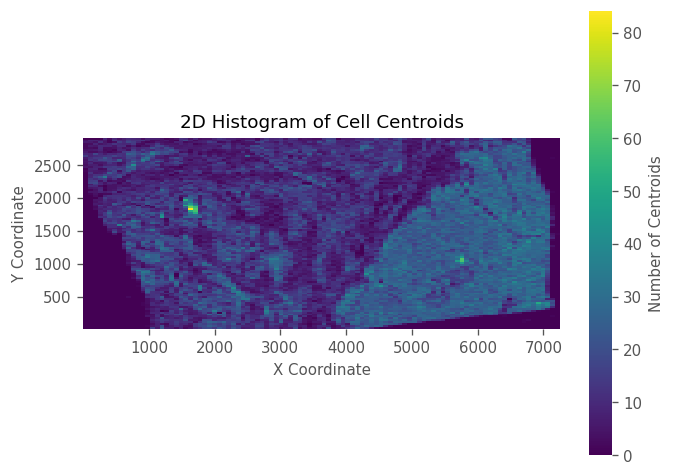

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming adata is your AnnData object and adata.obs contains x_centroid and y_centroid
x_centroid = adata.obs['x_centroid']
y_centroid = adata.obs['y_centroid']

# Define the number of bins for the histogram
num_bins = 100

# Create the 2D histogram
hist, xedges, yedges, im = plt.hist2d(x_centroid, y_centroid, bins=num_bins, cmap='viridis')

plt.gca().set_aspect('equal', adjustable='box')

# Add a colorbar
plt.colorbar(im, label='Number of Centroids')

plt.title('2D Histogram of Cell Centroids')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

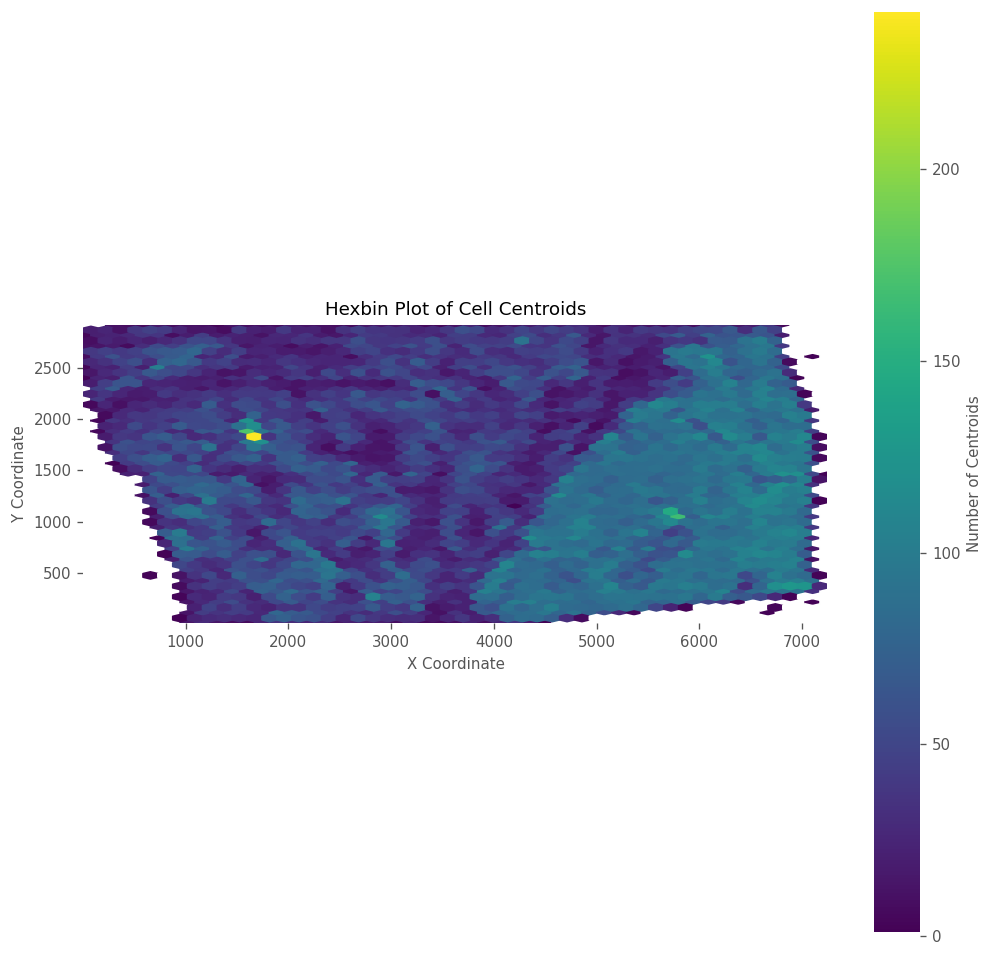

In [70]:
gridsize = 100  # Adjust this to control the resolution of the hexbin plot

# Create a colormap that starts with white (for zero counts)
cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (1,1,1,1)  # Set the color for zero counts to white
custom_cmap = ListedColormap(cmaplist)

# Create the hexbin plot
plt.figure(figsize=(10, 10))
hb = plt.hexbin(x_centroid, y_centroid, gridsize=gridsize, cmap=custom_cmap, mincnt=0)

# Ensure the aspect ratio is equal
plt.gca().set_aspect('equal', adjustable='box')

# Add a colorbar
plt.colorbar(hb, label='Number of Centroids')

plt.title('Hexbin Plot of Cell Centroids')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.xlim(min(x_centroid), max(x_centroid))
plt.ylim(min(y_centroid), max(y_centroid))
plt.show()


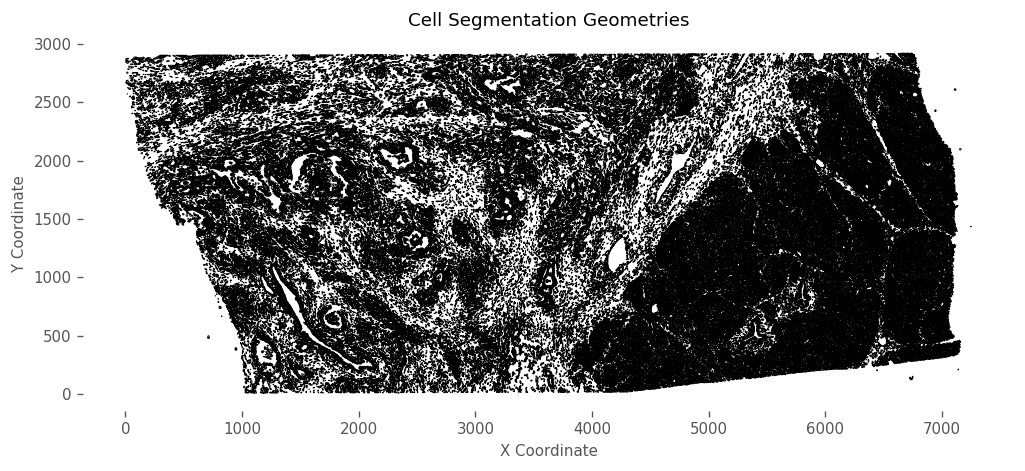

In [36]:
# Assuming adata is your AnnData object and adata.obsm['geometry']['cellSeg'] contains the geometries
cellSeg_series = adata.obsm['geometry']['cellSeg']

# Create a GeoDataFrame from the geometries
gdf = gpd.GeoDataFrame(geometry=cellSeg_series)

# Plot the geometries
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, edgecolor='k', facecolor='none')

plt.title('Cell Segmentation Geometries')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

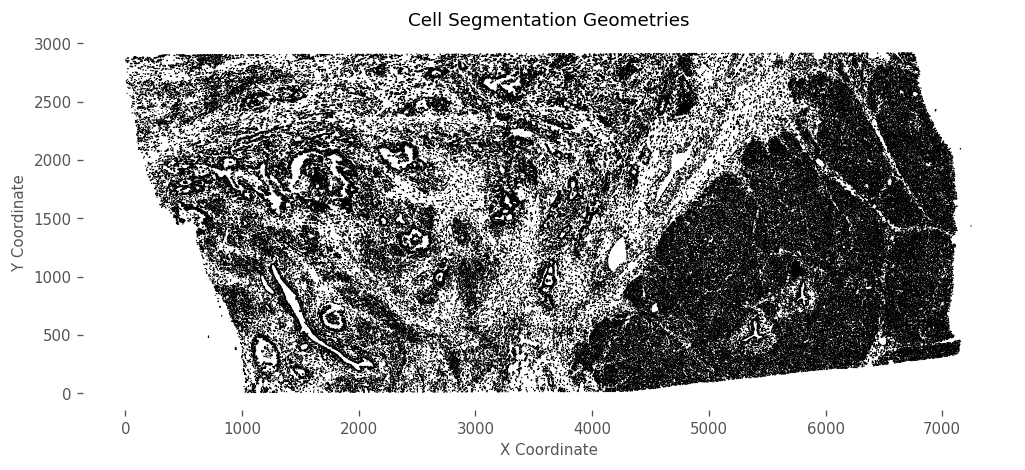

In [37]:
# Assuming adata is your AnnData object and adata.obsm['geometry']['cellSeg'] contains the geometries
nucSeg_series = adata.obsm['geometry']['nucSeg']

# Create a GeoDataFrame from the geometries
gdf = gpd.GeoDataFrame(geometry=nucSeg_series)

# Plot the geometries
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, edgecolor='k', facecolor='none')

plt.title('Nucleus Segmentation Geometries')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [ ]:
# Assuming adata is your AnnData object and adata.obsm['geometry']['cellSeg'] contains the geometries
cellSeg_series = adata.obsm['geometry']['cellSeg']

# Create a GeoDataFrame from the geometries
gdf = gpd.GeoDataFrame(geometry=cellSeg_series)

# Plot the geometries
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, edgecolor='k', facecolor='none')

plt.title('Cell Segmentation Geometries')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [72]:
adata.obs

,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area
aaaadnje-1,446.326691,1701.357300,37,0,0,0,0,37,44.117658,38.021564
aaacalai-1,441.307831,1735.877930,60,0,0,0,0,60,66.244221,33.912345
aaacjgil-1,466.053192,1712.259766,63,0,0,0,0,63,104.491566,52.697346
aaacpcil-1,430.858093,1707.464600,12,0,0,0,0,12,34.183282,17.520626
aaadhocp-1,476.111145,1711.089355,143,0,0,0,0,143,149.060787,51.116877
...,...,...,...,...,...,...,...,...,...,...
oiloppgp-1,6082.675781,555.142883,14,0,0,0,0,14,15.082188,15.082188
oilpccne-1,6106.899414,494.951843,2,0,0,0,0,2,5.734844,5.734844
oimacfoj-1,6080.991211,626.742126,11,0,0,0,0,11,13.682344,13.682344
oimaiaae-1,6030.594727,536.503418,18,0,0,0,0,18,17.701251,17.701251


/root/venv_list/voyagerpy_env/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


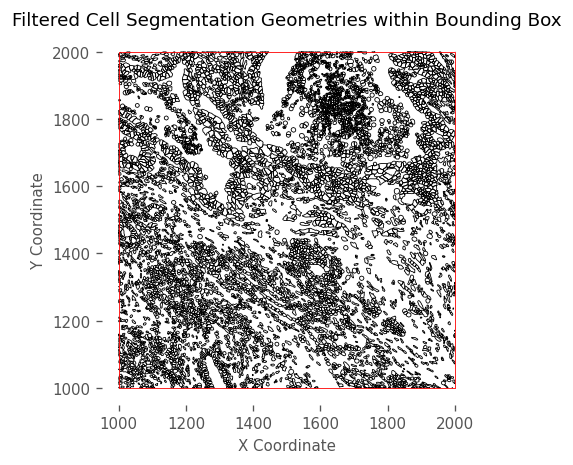

In [77]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box

# Assuming adata is your AnnData object and adata.obsm['geometry']['cellSeg'] contains the geometries
cellSeg_series = adata.obsm['geometry']['cellSeg']

# Create a GeoDataFrame from the geometries
gdf = gpd.GeoDataFrame(geometry=cellSeg_series)

# Define the bounding box (replace with your desired coordinates)
minx, miny, maxx, maxy = 1000, 1000, 2000, 2000
bounding_box = box(minx, miny, maxx, maxy)

cropped_gdf = gdf.intersection(bounding_box)

# Remove empty geometries that might result from the intersection
cropped_gdf = cropped_gdf[~cropped_gdf.is_empty]

# Plot the geometries within the bounding box
fig, ax = plt.subplots(figsize=(4,4))
cropped_gdf.plot(ax=ax, edgecolor='k', facecolor='none')

# Plot the bounding box for reference
bounding_box_gdf = gpd.GeoDataFrame(geometry=[bounding_box])
bounding_box_gdf.plot(ax=ax, edgecolor='r', facecolor='none')

plt.title('Filtered Cell Segmentation Geometries within Bounding Box')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


In [ ]:
# Ensure 'feature_type' is a categorical column
adata.var['feature_type'] = adata.var['feature_type'].astype('category')

# Initialize a DataFrame to store the results
feature_types = adata.var['feature_type'].cat.categories
obs_data = pd.DataFrame(index=adata.obs.index)

# Calculate the total counts per cell
total_counts_per_cell = adata.X.sum(axis=1)

# Calculate the fraction of counts for each feature type
for feature_type in feature_types:
    # Get the indices of genes belonging to the current feature type
    gene_indices = np.where(adata.var['feature_type'] == feature_type)[0]
    
    # Sum the counts of these genes for each cell
    counts_per_cell = adata.X[:, gene_indices].sum(axis=1)
    
    # Calculate the fraction of counts for the current feature type
    fraction_counts_per_cell = counts_per_cell / total_counts_per_cell
    
    # Store the result in obs_data
    obs_data[f'fraction_{feature_type}'] = fraction_counts_per_cell

# Add the calculated fractions to adata.obs
adata.obs = adata.obs.join(obs_data)

# Display the updated adata.obs to the user
import ace_tools as tools; tools.display_dataframe_to_user(name="Updated adata.obs", dataframe=adata.obs)

# Display the first few rows of adata.obs to verify
print(adata.obs.head())

<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


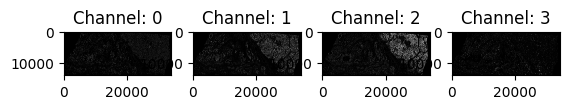

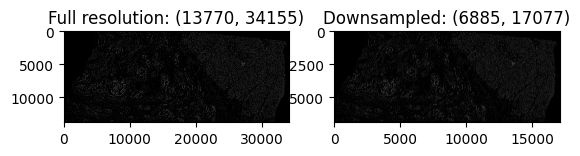

In [1]:
# Import Python libraries
# This code uses python v3.12.0, tifffile v2023.9.26, matplotlib v3.8.2
import tifffile
import matplotlib.pyplot as plt

file_path = '/workspace/examples/xenium/xenium2_pancreas/morphology_focus/morphology_focus_0000.ome.tif'

# Option 1: Load full resolution image channels
# The following may produce a warning: 'OME series cannot read multi-file pyramids'. This is because tifffile does not support loading a pyramidal multi-file OME-TIFF file. Only the full resolution (level=0) data will load for all channels in the directory.
fullres_multich_img = tifffile.imread(file_path, is_ome=True, level=0, aszarr=False)

# Examine shape of array (number of channels, height, width), e.g. (4, 40867, 31318)
fullres_multich_img.shape

# Extract number of channels, e.g. 4
n_ch = fullres_multich_img.shape[0]

# Plot each channel
fig, axes = plt.subplots(ncols=n_ch, nrows=1, squeeze=False)
for i in range(n_ch):
    axes[0, i].imshow(fullres_multich_img[i], cmap="gray")
    axes[0, i].set_title(f"Channel: {i}")
plt.savefig('tifffile_fullres_four_channels.png')

# Option 2: Load a single channel image at any resolution, e.g., level=0 or level=1. Note 'is_ome' is set to False.
# Load one of the multi-file OME-TIFF files as a regular TIFF file at full resolution.
fullres_img_tiff = tifffile.imread(
    file_path, is_ome=False, level=0)

# Now load the file at downsampled resolution
downsampled_img = tifffile.imread(
    file_path, is_ome=False, level=1)

# Plot the full resolution and downsampled images side-by-side
fig, axes = plt.subplots(ncols=2, nrows=1, squeeze=False)
axes[0, 0].imshow(fullres_img_tiff, cmap="gray")
axes[0, 0].set_title(f"Full resolution: {fullres_img_tiff.shape}")
axes[0, 1].imshow(downsampled_img, cmap="gray")
axes[0, 1].set_title(f"Downsampled: {downsampled_img.shape}")
plt.savefig('example_fullres_downsample.png')
